# Redes Neuronales Recurrentes (RNNs)

![RNN](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

La **red neuronal recurrente (RNN)** permite modelar unidades de memoria para persistir los datos y modelar dependencias a corto plazo. También se utiliza en la previsión de series temporales para la identificación de correlaciones y patrones de datos. Una red neuronal recurrente se parece bastante a una red neuronal tradicional, salvo que se añade un estado de memoria a las neuronas. La red se llama "recurrente" porque realiza la misma operación en cada celda de activación. La red calcula los pesos de las entradas y la salida anterior antes de utilizar una función de activación.

## Caso de estudio: ventas de coches

Para estudiar la capacidad de predicción de series temporales de las redes recurrentes vamos a construir un modelo para predecir el volumen de ventas que tendrá un concesionario en el próximo mes en función de las ventas de los meses anteriores. Este conjunto de datos entra claramente dentro de la familia de las series temporales.

El *dataset* está en un fichero CSV por lo que usaremos **Pandas** para cargarlo directamente en un `Dataframe`.

In [14]:
import pandas as pd

raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv',
    header=0, index_col=0, squeeze=True
)

raw_data.shape

(108,)

Observamos que nuestro conjunto de datos solo tiene una variable, que actuará al mismo tiempo de conjunto de entrenamiento y variable objetivo. Empieza a tomar sentido el término "recurrente", pues la varaible objetivo se va a predecir en función de ella misma. A esto se le conoce como **Predicción de series temporales uni-variadas**.

De acuerdo a la descripción del dataset:

> Monthly car sales in Quebec 1960-1968
>
> Source: Time Series Data Library (citing: Abraham & Ledolter (1983))

Tenemos volumen mensual de ventas de coches en Quebec

<AxesSubplot:xlabel='Month'>

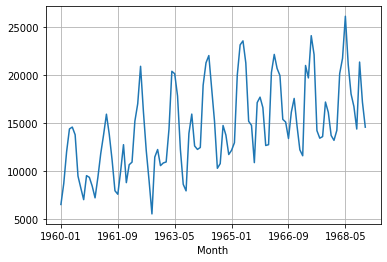

In [4]:
raw_data.plot(grid=True)

Un hiper-parámetro clave en el diseño de una red neuronal recurrente es el **tamaño de la ventana**, es decir, cuántas observaciones anteriores se van a utilizar para calcular la predicción. En este caso, lo primero que tenemos que decidir es cuántos meses previos va a utilizar nuestro modelo para calcular la predicción del mes siguiente. Además, estamos ante un **problema de regresión**, por lo que necesitaremos convertir los valores a número en coma flotante.

Supongamos que elegimos **5 meses previos** para calcular la predicción; tenemos que alimentar a la **RNN** con los datos en forma de ventana móvil de tamaño 5:

In [15]:
import numpy as np

raw_data = raw_data.values.astype('float32')

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.asarray(X), np.asarray(y)

X, y = split_sequence(raw_data, 12)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [16]:
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (96, 12, 1)
Shape de y: (96,)


In [28]:
X[:3]

array([[[ 6550.],
        [ 8728.],
        [12026.],
        [14395.],
        [14587.]],

       [[ 8728.],
        [12026.],
        [14395.],
        [14587.],
        [13791.]],

       [[12026.],
        [14395.],
        [14587.],
        [13791.],
        [ 9498.]]], dtype=float32)

In [29]:
y[:3]

array([13791.,  9498.,  8251.], dtype=float32)

Hacemos un *split* para entrenamiento y validación. Observa que, al estar trabajando con series temporales, **no debemos hacer un `shuffle`** de los datos, pues romperíamos la información temporal.

In [21]:
n_test = 12
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(84, 12, 1) (12, 12, 1) (84,) (12,)


Una vez preprocesada la información del problema, procedemos a construir la arquitectura de la RNN para resolverlo. La primera arquitectura que vamos a probar estará formada por celdas del tipo `SimpleRNN`, una RNN totalmente conectada en la que la salida del paso de tiempo anterior es la que alimenta el siguiente paso de tiempo.

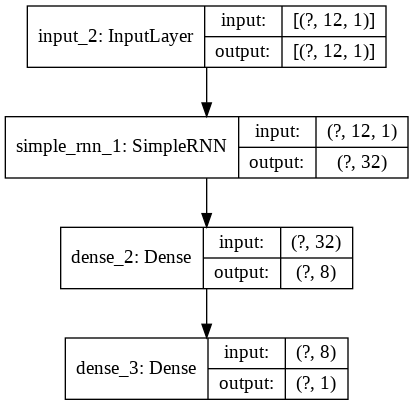

In [20]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.utils import plot_model

def create_rnn_sales():
    inputs = K.Input(shape=(12, 1))
    recurrent = K.layers.SimpleRNN(32, activation='relu', dropout=0.2)(inputs)
    dense = K.layers.Dense(8, activation='relu')(recurrent)
    outputs = K.layers.Dense(1)(dense)
    
    return K.Model(inputs=inputs, outputs=outputs, name='SimpleRNN')
plot_model(create_rnn_sales(), show_layer_names=True, show_shapes=True)

In [6]:
import matplotlib.pyplot as plt

def plot_train_val_mae(history, y_scale='linear'):
    plt.rcParams['figure.figsize'] = [15, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    
    ax1.plot(history.history['loss'], label='loss (train)')
    ax1.plot(history.history['val_loss'], label='loss (val)')
    ax1.set_title('Loss')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.set_yscale(y_scale)
    ax2.plot(history.history['mae'], label='MAE (train)')
    ax2.plot(history.history['val_mae'], label='MAE (val)')
    ax2.set_title('MAE')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.set_yscale(y_scale)
    ax1.grid()
    ax2.grid()
    plt.plot()

Procedemos a entrenar y evaluar el modelo RNN como cualquier otro modelo de Deep Learning que ya hemos trabajado. Ya que estamos ante un problema de regresión, usaremos **MSE** como función de coste:

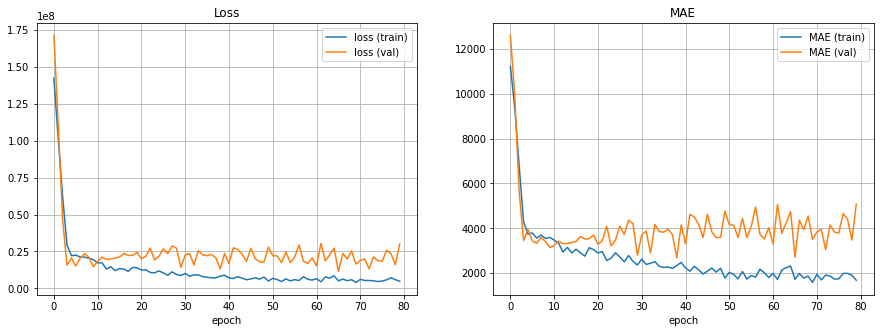

In [22]:
with tf.device('/device:GPU:0'):
    tf.keras.backend.clear_session()
    model_rnn = create_rnn_sales()
    model_rnn.compile(
        loss='mse', 
        optimizer='adam',
        metrics=['mae'])
    history = model_rnn.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=80, batch_size=16, verbose=0)
    plot_train_val_mae(history)

In [10]:
mse, mae = model_rnn.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, np.sqrt(mse), mae))

MSE: 10768638.000, RMSE: 3281.560, MAE: 2844.980


In [23]:
yhat = model_rnn.predict(X)

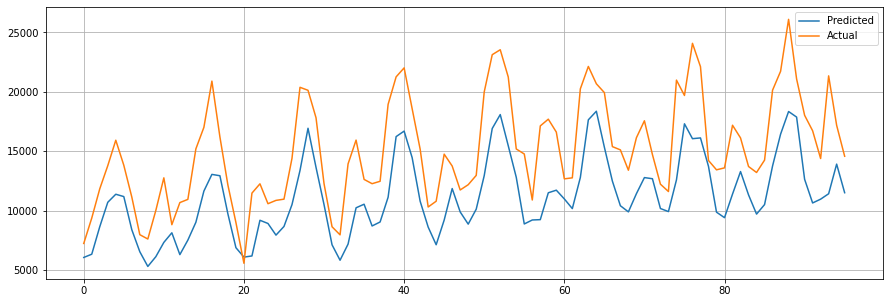

In [25]:
plt.plot(yhat, label='Predicted')
plt.plot(y, label='Actual')
plt.legend()
plt.grid()
plt.show()

Una evaluación del modelo entrenado nos arroja unos errores absolutos medios de, aproximadamente, 2500 unidades de ventas. No hemos realizado ningún tipo de normalización a los datos de entrada. Además, el conjunto de datos es muy pequeño, con unas cuantas observaciones.

## Caso de estudio: precio de una acción

En este caso de estudio vamos a intentar resolver un problema de predicción de series temporales multi-variadas, es decir, aquellas series temporales en las que la variable objetivo depende de varias variables de entrada. En concreto, vamos a intentar predecir el precio de una acción en función de algunas variables y métricas calculadas para esa acción en instantes anteriores.

Para obtener información sobre el precio de las acciones vamos a usar un paquete de Python que transforma la información financiera de sitios como *Yahoo Finance* directamente en un *dataframe* de *Pandas*.

In [81]:
import datetime
import pandas_datareader.data as web

raw_data = web.DataReader(
    "AAPL",
    "yahoo",
    datetime.datetime(2010, 1, 1),
    datetime.datetime(2020, 12, 31)
)
raw_data.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.572422
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.583784
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.479061
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.467082
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.510078


<AxesSubplot:xlabel='Date'>

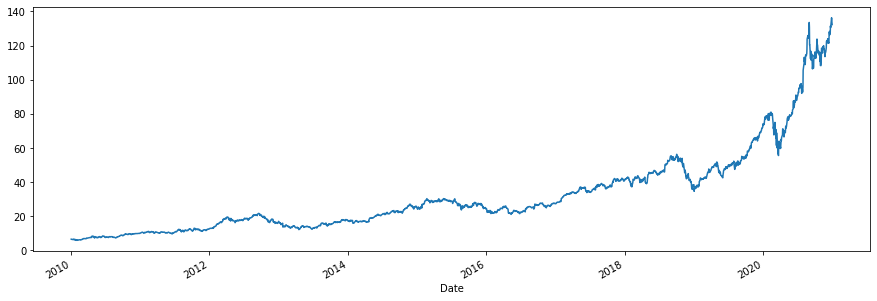

In [83]:
raw_data['Adj Close'].plot()

En lugar de usar una función propia para crear la ventana móvil vamos a utilizar un **data generator** especializado en las series temporales.

In [102]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
y = raw_data['Adj Close']
X = raw_data.drop(['Adj Close'], axis=1)

X = scaler.fit_transform(X)

n_test = 400
DAYS = 14 # Usaremos los 14 días anteriores
BATCH_SIZE = 64

X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

train_generator = K.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=DAYS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_generator = K.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=DAYS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

(2369, 5) (400, 5) (2369,) (400,)


Vamos a utilizar esta vez celdas Long-Short Term Memory (LSTMs) para construir el modelo de red neuronal recurrente. Este tipo de celdas supone una mejora con respecto a la simple ya que, entre otras cosas, evita el problema de la fuga de gradiente. Además, vamos a añadir al inicio una capa de normalización para dejar los valores de las variables de entrada normalizados. Por último, una capa con una única neurona para la salida.

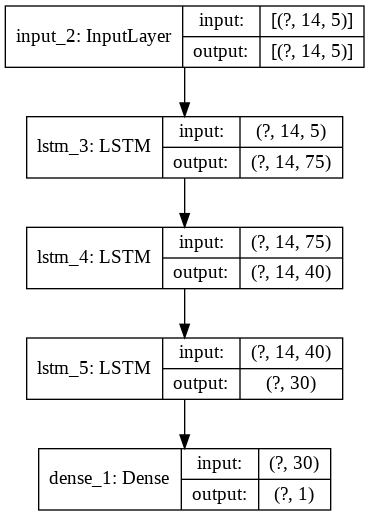

In [103]:
def create_stock():
    ins = K.Input(shape=(DAYS, X_train.shape[1]))
    lstm = K.layers.LSTM(75, return_sequences=True, activation='relu')(ins)
    lstm = K.layers.LSTM(40, return_sequences=True, activation='relu')(lstm)
    lstm = K.layers.LSTM(30, activation='relu')(lstm)
    outs = K.layers.Dense(1)(lstm)
    
    return K.Model(inputs=ins, outputs=outs, name='StockNaive')
plot_model(create_stock(), show_layer_names=True, show_shapes=True)

Entrenamos y evaluamos el modelo:

Epoch 1/15
37/37 [==============================] - 27s 730ms/step - loss: 505.4006 - mae: 20.1751 - val_loss: 343890.9688 - val_mae: 397.0409
Epoch 2/15
37/37 [==============================] - 24s 660ms/step - loss: 276.6071 - mae: 14.7976 - val_loss: 105656.9844 - val_mae: 221.7503
Epoch 3/15
37/37 [==============================] - 26s 704ms/step - loss: 70.1980 - mae: 7.1072 - val_loss: 8776.6670 - val_mae: 58.4731
Epoch 4/15
37/37 [==============================] - 24s 657ms/step - loss: 68.2819 - mae: 7.3015 - val_loss: 5711.5015 - val_mae: 47.5826
Epoch 5/15
37/37 [==============================] - 24s 658ms/step - loss: 67.5387 - mae: 7.1030 - val_loss: 5180.4414 - val_mae: 48.6130
Epoch 6/15
37/37 [==============================] - 24s 655ms/step - loss: 88.0396 - mae: 8.2738 - val_loss: 5343.4653 - val_mae: 53.1947
Epoch 7/15
37/37 [==============================] - 27s 720ms/step - loss: 55.3037 - mae: 6.2315 - val_loss: 3107.3772 - val_mae: 37.5087
Epoch 8/15
37/37 [======

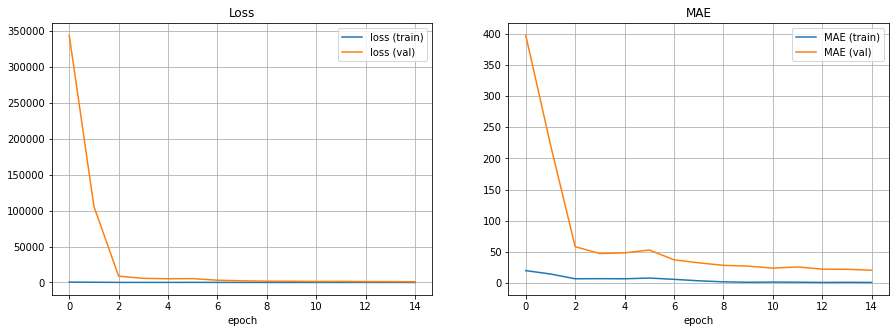

In [104]:
with tf.device('/device:GPU:1'):
    tf.keras.backend.clear_session()
    stock = create_stock()
    stock.compile(
        loss='mse', 
        optimizer='adam',
        metrics=['mae'])
    history_stock = stock.fit(
        train_generator, 
        validation_data=test_generator,
        epochs=15, verbose=1,
        shuffle=False
    )
plot_train_val_mae(history_stock)

Una vez tenemos entrenado el modelo, podemos utilizarlo para comparar el precio predicho con respecto al real en una gráfica.

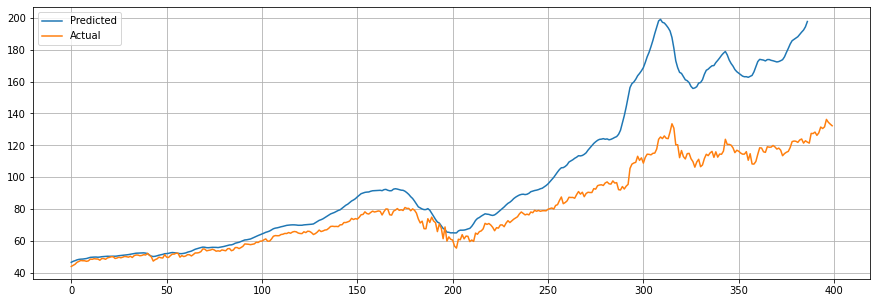

In [106]:
yhat = stock.predict(test_generator)

plt.plot(yhat, label='Predicted')
plt.plot(y_test.values, label='Actual')
plt.legend()
plt.grid()
plt.show()

## Caso de estudio: generación de texto

Además de usarse para tareas de clasificación y regresión, las **redes neuronales recurrentes** han demostrado su utilidad a la hora de crear modelos generativos de lenguaje, es decir, modelos capaces de construir textos.

Para este ejemplo vamos a construir un modelo generativo para construir oraciones basadas en *El Quijote* de Cervantes. Para ello, lo primero que tenemos que hacer es descargar la novela en texto plano:

In [31]:
import urllib

url = r"https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt"
file = urllib.request.urlopen(url)

quijote = []
for line in file:
    quijote.append(line.decode("utf-8").replace('\n', ''))

quijote = ' '.join(quijote)
quijote[:500]

'DON QUIJOTE DE LA MANCHA Miguel de Cervantes Saavedra  PRIMERA PARTE CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los'

Para poder utilizar nuestros datos de texto con una RNN necesitamos transformarlos a valores numéricos. Vamos a crear una secuencia de caracteres como nuestros datos de entrada `X` y utilizaremos el siguiente carácter como nuestro valor de la variable de salida `Y`. Por último, transformaremos nuestros datos en un array de booleanos.

In [32]:
chars = sorted(list(set(quijote))) # Conjunto de caractéres únicos encontrados en el texto
print(f'{len(chars)} caracteres diferentes encontrados en el texto')

# Mapeados char -> int, int -> char
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

88 caracteres diferentes encontrados en el texto


Para obtener datos útiles que podamos utilizar para entrenar nuestro modelo, dividiremos nuestros datos en subsecuencias con una longitud de $N$ caracteres. Luego transformaremos nuestros datos en una matriz booleana.

In [33]:
N = 100
sentences = []
next_chars = []
for i in range(0, len(quijote) - N):
    sentences.append(quijote[i: i + N])
    next_chars.append(quijote[i + N])

X = np.zeros((len(sentences), N, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [158]:
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (1038296, 100, 88)
Shape de y: (1038296, 88)


Una vez preparado el *dataset*, procedemos a construir una RNN para generar nuevas oraciones. Utilizaremos algunas capas **LSTM** para terminar con una capa de salida con tantas neuronas como caracteres distintos se hayan identificado en el texto original. De esta forma nos encontramos ante un problema de clasificación que podría enunciarse de la siguiente manera:

> Dada la siguiente secuencia de $N$ caracteres, ¿cuál debe ser el siguiente?


In [38]:
import tensorflow as tf
import tensorflow.keras as K

def create_quijote():
    ins = K.Input(shape=(N, len(chars)))
    lstm = K.layers.LSTM(128, return_sequences=True)(ins)
    lstm = K.layers.LSTM(100, return_sequences=True)(lstm)
    lstm = K.layers.LSTM(64)(lstm)
    outs = K.layers.Dense(len(chars), activation='softmax')(lstm)
    model = K.Model(inputs=ins, outputs=outs)
    print(model.summary())
    return model

Para ver las mejoras que hace nuestro modelo durante el entrenamiento crearemos dos funciones de ayuda. Estas dos funciones están extraídas del [ejemplo oficial de generación de texto LSTM](https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py) del equipo Keras.

La primera función de ayuda muestreará un índice de la salida (matriz de probabilidad). Tiene un parámetro llamado temperatura que define la libertad que tiene la función al crear el texto. La segunda generará texto con cuatro temperaturas diferentes al final de cada *epoch* para que podamos ver cómo lo hace nuestro modelo.

In [35]:
import sys

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = np.random.randint(0, len(quijote) - N - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = quijote[start_index: start_index + N]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, N, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = cervantes.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
print_callback = K.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

También vamos a utilizar un *callback* para ajustar la tasa de aprendizaje del optimizador de manera dinámica en función del progreso en el entrenamiento. Vamos a usar [`ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

In [36]:
reduce_lr = K.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.001)

In [39]:
with tf.device('/device:GPU:1'):
    tf.keras.backend.clear_session()
    cervantes = create_quijote()
    cervantes.compile(
        loss='categorical_crossentropy', 
        optimizer=K.optimizers.RMSprop(learning_rate=0.01),
        metrics=['accuracy'])
    history_cervantes = cervantes.fit(
        X, 
        y,
        epochs=5,
        batch_size=512,
        callbacks=[print_callback, reduce_lr]
    )

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 88)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          111104    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          91600     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 88)                5720      
Total params: 250,664
Trainable params: 250,664
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
2028/2028 [==============================] - ETA: 0s - loss: 1.8677 - accuracy: 0.4331
----- Genera

<ipython-input-35-9b18e6013668>:6: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


e su padre de la casa los de los muchos casas de la mano de los partes de los días y a los más de los más de la cabe
----- diversity: 0.5
----- Generating with seed: " escondido. -Toma bien las señas; que yo procuraré no apartarme destos contornos -dijo don Quijote"
 escondido. -Toma bien las señas; que yo procuraré no apartarme destos contornos -dijo don Quijote, y el cura de ron el caballos muchos altas las días estar de acabado con la mano de mi cabada de los cabreros. El discrecirlo la mal de los caballeros de su casa de su despereciala, así que le respondió el barbero de su veces de Anselmo la cabeza que no sólo que diciendo los días que se quisieran lustón de menos a pensamiento y escudido los caballerías de juntos y su muchos buenas más las
----- diversity: 1.0
----- Generating with seed: " escondido. -Toma bien las señas; que yo procuraré no apartarme destos contornos -dijo don Quijote"
 escondido. -Toma bien las señas; que yo procuraré no apartarme destos co

 lugar a que el autor pueda mostrarse épico, lírico, trágico, cómico, con todas aquellas partes de la caballeriza de la merced de los que le dejara en esto que estaba de los que se había de ser en la caballería que se le había de para que a la caballería que era en el cura de la pregunta de la cabeza de la como el cura de la caballería que está en un caballero de la cabeza de la caballería de la caballería que estaba en ella de los compañeros de la mesma caballero de la merced le ha
----- diversity: 0.5
----- Generating with seed: " lugar a que el autor pueda mostrarse épico, lírico, trágico, cómico, con todas aquellas partes "
 lugar a que el autor pueda mostrarse épico, lírico, trágico, cómico, con todas aquellas partes a los de que se le acometiá a estos seguir los que le debajo que le daron por pendidad de esperanza de aquí estaba que estaba de la merced de una vez de que me había de a la mesma aventura la vuestra repuenza de mi estado de la cual apeaa en el

Guardamos en fichero el modelo ya entrenado para recuperarlo más adelante.

In [41]:
cervantes.save('cervantes.tf')

INFO:tensorflow:Assets written to: cervantes.tf/assets


Para generar el texto nosotros mismos crearemos una función similar a la función `on_epoch_end`. Tomará un índice inicial aleatorio, sacará los siguientes $N$ caracteres del texto y los utilizará para hacer predicciones. Como parámetro le pasaremos la longitud del texto que queremos generar y la diversidad del texto generado.

In [42]:
def generate_text(length, diversity):
    # Get random starting text
    start_index = np.random.randint(0, len(quijote) - N - 1)
    generated = ''
    sentence = quijote[start_index: start_index + N]
    generated += sentence
    for i in range(length):
            x_pred = np.zeros((1, N, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = cervantes.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char
    return generated

In [45]:
print(generate_text(500, 0.9))

<ipython-input-35-9b18e6013668>:6: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


e me la trasladó del entendimiento tan punto por punto, que dijo que en todos los días de su vida, voy hacer leer de Dorotea quien quedan agora le verés, porque de temer, se falase de ángodas por ella, advirtió Dorotea que no le daron corroficia, que le había cuento, este esta calaña Mesco que un granquero y todo el molido el de uno!  ¿Sí apear encima adara y la buena veceste que penada de caballero se admirielo, y asiendo las improsos, lo que se abrárla su ama conocido a los comodades te respondarse. Olga solicitud que entá Camila, y, confura, ni a Sancho; y que la forta de las aqui


---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">